###Download the dataset from google drive url (public)


In [ ]:
!pip install gdown --quiet

import gdown

# Google Drive file ID (from your URL)
file_id = '123456789'  # Replace with the actual file ID

# Output path with filename
output_path = '/content/Insect_Dataset.tar.xz'  # change filename accordingly

# Download
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

print(f"File downloaded to {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA
From (redirected): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA&confirm=t&uuid=5a8ad422-12e8-423e-bb51-7e1127458981
To: /content/Insect_Dataset.tar.xz
100%|██████████| 654M/654M [00:07<00:00, 92.2MB/s]

File downloaded to /content/Insect_Dataset.tar.xz


###Extract dataset

In [2]:
!tar -xf Insect_Dataset.tar.xz

###Import necessary libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

### Transformers for augmentation and





In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [5]:
import os
import random
import shutil

data_dir = '/content/Insect_Dataset'
split_dir = '/content/Insect_Dataset_Split'  # new folder to save splits
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Make split folders
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Loop over each class folder
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all images and shuffle
    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    # Copy images to new folders
    for split, split_images in splits.items():
        dest_class_dir = os.path.join(split_dir, split, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        for img in split_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(dest_class_dir, img)
            shutil.copy2(src, dst)

print("Dataset split completed!")


Dataset split completed!


### Load image files and perform transformation

In [6]:
data_dir = '/content/Insect_Dataset_Split'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Classes: {num_classes}")


Classes: 15


In [7]:

# from torch.utils.data import random_split

# dataset = datasets.ImageFolder('/content/Insect_Dataset', transform=train_transforms)
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


### Load the model

In [8]:
model = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

### Setup: Device, Loss, Optimizer, and LR Scheduler"

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

### Model training

In [10]:
!pip install tqdm --quiet
from tqdm import tqdm

EPOCHS = 20
best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for i, (imgs, labels) in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_description(f"Train Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=running_loss/(i+1), acc=100.*correct/total)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss = val_loss / len(val_loader)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # --- Save best model ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_effnetv2.pth')
        print(f"✅ Best model saved with Val Acc: {best_acc:.2f}%")


Epoch 1/20


Train Loss: 1.2830 | Train Acc: 61.14% | Val Loss: 0.6637 | Val Acc: 79.60%
✅ Best model saved with Val Acc: 79.60%

Epoch 2/20


Train Loss: 0.7154 | Train Acc: 77.30% | Val Loss: 0.5683 | Val Acc: 81.27%
✅ Best model saved with Val Acc: 81.27%

Epoch 3/20


Train Loss: 0.5817 | Train Acc: 81.54% | Val Loss: 0.5202 | Val Acc: 84.03%
✅ Best model saved with Val Acc: 84.03%

Epoch 4/20


Train Loss: 0.5079 | Train Acc: 83.85% | Val Loss: 0.5119 | Val Acc: 83.84%

Epoch 5/20


Train Loss: 0.4329 | Train Acc: 86.04% | Val Loss: 0.4706 | Val Acc: 85.95%
✅ Best model saved with Val Acc: 85.95%

Epoch 6/20


Train Loss: 0.3809 | Train Acc: 88.03% | Val Loss: 0.4784 | Val Acc: 85.89%

Epoch 7/20


Train Loss: 0.3316 | Train Acc: 89.71% | Val Loss: 0.4721 | Val Acc: 86.53%
✅ Best model saved with Val Acc: 86.53%

Epoch 8/20


Train Loss: 0.3048 | Train Acc: 90.29% | Val Loss: 0.4632 | Val Acc: 87.11%
✅ Best model saved with Val Acc: 87.11%

Epoch 9/20


Train Loss: 0.2961 | Train Acc: 90.63% | Val Loss: 0.4605 | Val Acc: 87.24%
✅ Best model saved with Val Acc: 87.24%

Epoch 10/20


Train Loss: 0.2770 | Train Acc: 91.04% | Val Loss: 0.4574 | Val Acc: 87.36%
✅ Best model saved with Val Acc: 87.36%

Epoch 11/20


Train Loss: 0.2699 | Train Acc: 91.69% | Val Loss: 0.4644 | Val Acc: 87.17%

Epoch 12/20


Train Loss: 0.2771 | Train Acc: 91.32% | Val Loss: 0.4695 | Val Acc: 87.17%

Epoch 13/20


Train Loss: 0.2775 | Train Acc: 91.16% | Val Loss: 0.4649 | Val Acc: 87.43%
✅ Best model saved with Val Acc: 87.43%

Epoch 14/20


Train Loss: 0.2865 | Train Acc: 90.93% | Val Loss: 0.4587 | Val Acc: 87.36%

Epoch 15/20


Train Loss: 0.2721 | Train Acc: 91.44% | Val Loss: 0.4717 | Val Acc: 86.72%

Epoch 16/20


Train Loss: 0.2863 | Train Acc: 91.04% | Val Loss: 0.4740 | Val Acc: 87.04%

Epoch 17/20


Train Loss: 0.2836 | Train Acc: 90.96% | Val Loss: 0.5178 | Val Acc: 86.47%

Epoch 18/20


Train Loss: 0.2811 | Train Acc: 91.01% | Val Loss: 0.4851 | Val Acc: 87.04%

Epoch 19/20


Train Loss: 0.2662 | Train Acc: 91.62% | Val Loss: 0.5435 | Val Acc: 84.80%

Epoch 20/20


Train Loss: 0.2745 | Train Acc: 91.16% | Val Loss: 0.5529 | Val Acc: 86.40%


### Evaluate

In [11]:
model.load_state_dict(torch.load('best_effnetv2.pth'))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))



                            precision    recall  f1-score   support

Mango flat beak leafhopper       0.94      0.88      0.91        56
         alfalfa plant bug       0.94      0.82      0.88        82
            alfalfa weevil       0.79      0.73      0.76       108
                 army worm       0.89      0.96      0.92       410
        asiatic rice borer       0.60      0.59      0.59        51
                  beet fly       0.93      0.96      0.94        80
        brown plant hopper       0.84      0.72      0.78        90
                corn borer       0.80      0.75      0.78       108
                 green bug       0.83      0.67      0.74        72
         paddy stem maggot       0.57      0.74      0.64       106
          rice leaf roller       0.57      0.50      0.53        50
           rice shell pest       0.93      0.98      0.95        86
       tarnished plant bug       0.96      0.96      0.96       140
       white margined moth       0.89      0.84

### Confusion Matrix

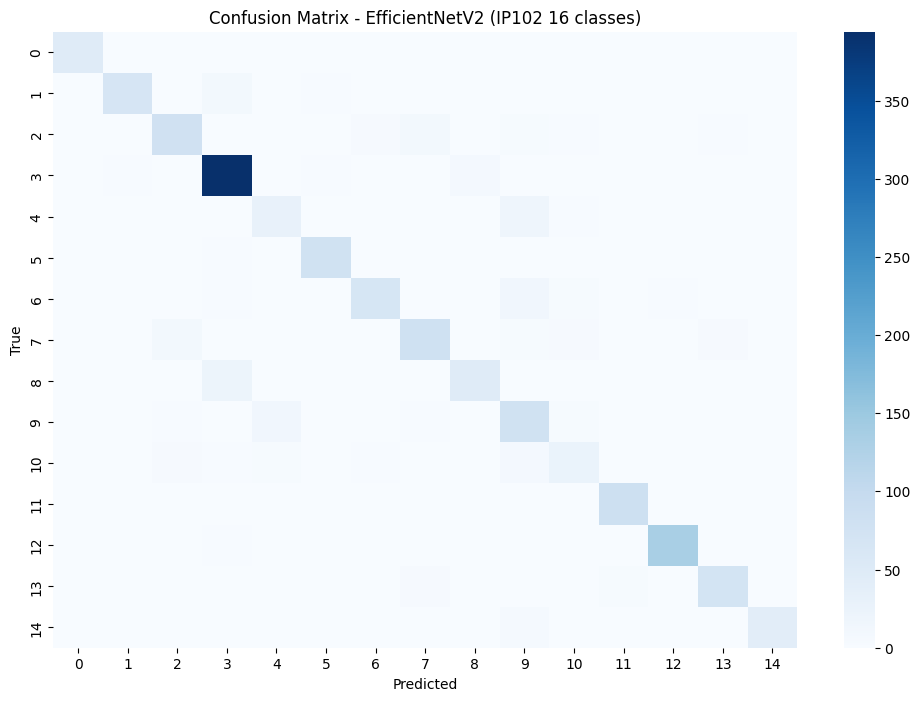

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - EfficientNetV2 (IP102 16 classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()